Import Libraries

In [2]:
import librosa
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def extract_features(audio_path):
    audio, sample_rate = librosa.load(audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed

def augment_audio(audio, sample_rate):
    # Add random noise
    noise = np.random.randn(len(audio))
    augmented_audio = audio + 0.005 * noise

    # Pitch shifting
    pitch_shifted = librosa.effects.pitch_shift(augmented_audio, sr=sample_rate, n_steps=4)

    # Time stretching
    time_stretched = librosa.effects.time_stretch(pitch_shifted, rate=0.8)
    
    return time_stretched

def extract_augmented_features(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    augmented_audio = augment_audio(audio, sample_rate)
    mfccs = librosa.feature.mfcc(y=augmented_audio, sr=sample_rate, n_mfcc=20)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed

In [6]:
def load_data(base_dir, protocol_path, augment = False):
    data = pd.read_csv(protocol_path, sep=' ', header=None, names=['speaker_id','filename','system_id','null','class_name'])
    features, labels = [], []
    for index, row in data.iterrows():
        file_path = os.path.join(base_dir, row['filename'] + '.flac')
        # print(file_path)
        if augment:
            mfcc = extract_augmented_features(file_path)
        else:
            mfcc = extract_features(file_path)
        features.append(mfcc)
        labels.append(1 if row['class_name'] == 'bonafide' else 0)
    return np.array(features), np.array(labels)

In [ ]:
def plot_mfccs(features, labels):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette='viridis', alpha=0.5)
    plt.title('MFCCs Feature Distribution')
    plt.xlabel('MFCC 1')
    plt.ylabel('MFCC 2')
    plt.legend(title='Label', labels=['Fake', 'Real'])
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [3]:
# Path to the training dataset and protocol
base_dir = './input/asvspoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac'
protocol_path = './input/asvspoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
# protocol_path = './input/asvspoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/protocol_testinf.txt'

With Augmentation

In [ ]:
# Load and prepare the dataset
AugX, Augy = load_data(base_dir, protocol_path, True)

In [ ]:
plot_mfccs(AugX,Augy)
# Split the dataset into training and test sets
AugX_train, AugX_test, Augy_train, Augy_test = train_test_split(AugX, Augy, test_size=0.25, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(AugX_train, Augy_train)

# Evaluate the model
Aug_predictions = model.predict(AugX_test)
Aug_accuracy = accuracy_score(Augy_test, Aug_predictions)

print(f'Accuracy for logistical Regression Model with Augmented Audio: {Aug_accuracy:.2f}')

plot_confusion_matrix(Augy_test, Aug_predictions)

Without Augmentation

In [ ]:
# Load and prepare the dataset without Audio Augmentation
X, y = load_data(base_dir, protocol_path)

Logistic Regression Model

In [ ]:
plot_mfccs(X,y)
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)



# Evaluate the model
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')
plot_confusion_matrix(y_test, predictions)

CNN Model

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def cnn_load_data(base_dir, protocol_path,output_spectrogram_dir): 

    # Create output directories if they don't exist
    os.makedirs(output_spectrogram_dir, exist_ok=True)


    real_output_dir = os.path.join(output_spectrogram_dir, 'real')
    fake_output_dir = os.path.join(output_spectrogram_dir, 'fake')

    os.makedirs(real_output_dir, exist_ok=True)
    os.makedirs(fake_output_dir, exist_ok=True)
    
    real_val_dir = './output/validation/real'
    fake_val_dir = './output/validation/fake'
    data = pd.read_csv(protocol_path, sep=' ', header=None, names=['speaker_id','filename','system_id','null','class_name'])
    for index, row in data.iterrows():
        file_path = os.path.join(base_dir, row['filename'] + '.flac')
        if row['class_name'] == 'bonafide':
            if not os.path.exists(os.path.join(real_output_dir, row['filename']+'.png')) and not os.path.exists(os.path.join(real_val_dir, row['filename']+'.png')):
                process_directory(row['filename'], real_output_dir)
                print("Real Happening")
        else:
            if not os.path.exists(os.path.join(fake_output_dir, row['filename']+'.png')) and not os.path.exists(os.path.join(fake_val_dir, row['filename']+'.png')):
                process_directory(row['filename'], fake_output_dir)
                print("Fake Happening")


def save_spectrogram(audio, sample_rate, filename):
    stft = librosa.stft(audio)
    db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(db, sr=sample_rate, x_axis='time', y_axis='log', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.savefig(filename)
    plt.close()


def process_directory(filename, output_dir):
    audio_path = os.path.join(base_dir, filename+'.flac')
    audio, sample_rate = librosa.load(audio_path, sr=None)
    output_filename = os.path.join(output_dir, os.path.splitext(filename)[0] + '.png')
    save_spectrogram(audio, sample_rate, output_filename)



def create_datagen(train_dir, val_dir, img_width, img_height, batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary'
    )

    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    return train_generator, validation_generator


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

def create_cnn_model(input_shape):
    model = Sequential([
        Input(input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming the spectrograms are 150x150 pixels
model = create_cnn_model((150, 150, 3))


In [9]:
cnn_load_data(base_dir, protocol_path, './output/spectograms')

# Split the data into training(75%) and testing(25%) using the following commands on the terminal
# mv -- *([1,5700]) output/validation/fake
# mv -- *([1,645]) output/validation/real

In [15]:
from PIL import Image
import os

def validate_images(image_directory):
    for root, dirs, files in os.walk(image_directory):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                try:
                    img_path = os.path.join(root, file)
                    img = Image.open(img_path)  # Open the image file
                    img.verify()  # Verify that it is, in fact, an image
                except (IOError, SyntaxError) as e:
                    print('Bad file:', img_path)  # Print out the names of corrupt files

validate_images('./output/spectograms/real')
validate_images('./output/spectograms/fake')
validate_images('./output/validation/real')
validate_images('./output/validation/fake')


In [16]:

train_generator,validation_generator = create_datagen('./output/spectograms','./output/validation', 150, 150, 32)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)



Found 19114 images belonging to 2 classes.
Found 6345 images belonging to 2 classes.
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


598/598 ━━━━━━━━━━━━━━━━━━━━ 292s 484ms/step - accuracy: 0.8989 - loss: 0.2619 - val_accuracy: 0.9116 - val_loss: 0.1811
Epoch 2/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 294s 487ms/step - accuracy: 0.9013 - loss: 0.2208 - val_accuracy: 0.9231 - val_loss: 0.1627
Epoch 3/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 294s 487ms/step - accuracy: 0.9032 - loss: 0.2111 - val_accuracy: 0.9340 - val_loss: 0.1526
Epoch 4/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 318s 527ms/step - accuracy: 0.9141 - loss: 0.1949 - val_accuracy: 0.9266 - val_loss: 0.1451
Epoch 5/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 316s 524ms/step - accuracy: 0.9171 - loss: 0.1927 - val_accuracy: 0.9362 - val_loss: 0.1348
Epoch 6/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 319s 529ms/step - accuracy: 0.9208 - loss: 0.1790 - val_accuracy: 0.9351 - val_loss: 0.1543
Epoch 7/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 324s 537ms/step - accuracy: 0.9240 - loss: 0.1844 - val_accuracy: 0.9318 - val_loss: 0.1497
Epoch 8/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 320s 531ms/step - accuracy: 0.9248 - loss: 0.17

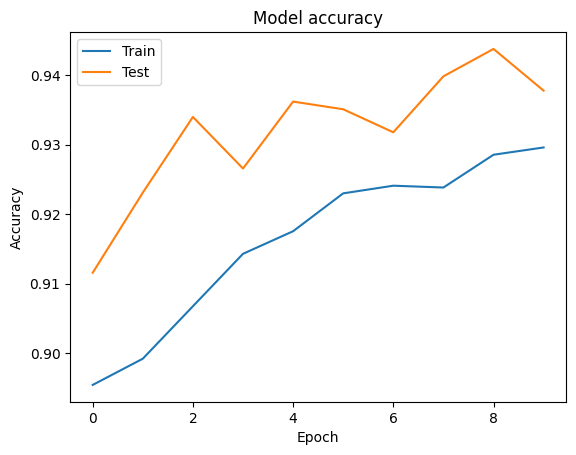

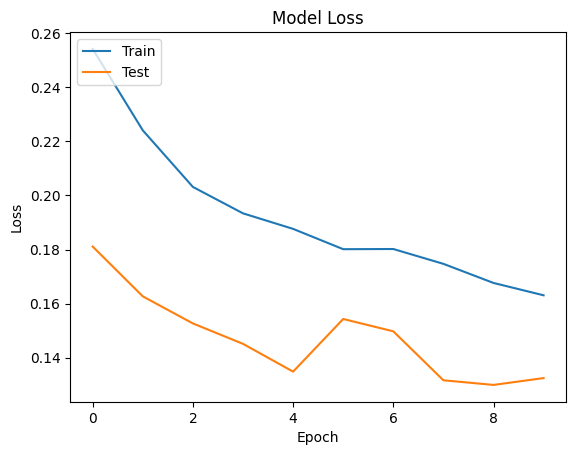

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



199/199 ━━━━━━━━━━━━━━━━━━━━ 62s 312ms/step


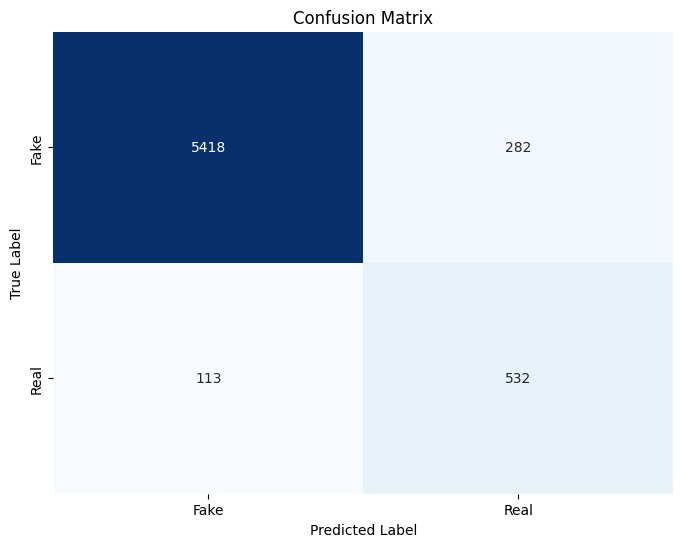

In [18]:
# x_train_batch, y_train_batch = next(train_generator)
# x_test_batch, y_test_batch = next(validation_generator)

validation_generator.reset()  # Reset the generator to be sure of the order
predictions = model.predict(validation_generator)

y_pred = (predictions > 0.5).astype(int)  # Convert probabilities to 0 or 1

y_true = validation_generator.classes[:len(y_pred)]  # Ensure the length matches y_pred if the last batch is incomplete

cm = confusion_matrix(y_true, y_pred)

class_names = ['Fake', 'Real']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)  # Assumes the positive class is 1
precision = precision_score(y_true, y_pred)  # Assumes the positive class is 1
f1 = f1_score(y_true, y_pred)  # Harmonic mean of precision and recall

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.94
Recall: 0.82
Precision: 0.65
F1 Score: 0.73
